# Introduction

Utiliser l'environnement _emigration_, cf. les instructions de la page d'accueil du dépôt et le fichier _environment.yml_

In [64]:
import pprint, re, os, glob
from lxml import etree as etree
import pandas as pd
from matplotlib import pyplot as plt
from itertools import groupby
import sqlite3

### Liste des fichiers à traiter

* Définir les chemins des dossiers où se trouvent les fichiers
* Lister les fichiers du dossier XML

In [2]:
### Chemin des documents en .docx
folder_path = 'fichiers/'
### Chemin du dossier des documents transformes 
folder_path_xml = 'fichiers_xml/'


In [3]:
l_docs = []
for d in os.listdir(folder_path_xml):
    # vérifie que le document ne commence pas avec un '.', particularité MacOS pour docs ouverts
    if d[0] != '.':
        if('.html' in d):
            l_docs.append(d)



In [4]:
len(l_docs), l_docs[:5]

(13,
 ['d27_alaidon_sans.html',
  'd85_richard_sans.html',
  'd6_chaillou_sans.html',
  'd44_artigues_sans.html',
  'd11_valeix_sans.html'])

## Exploration des documents produits

* transformer en XML les fichier HTML
* en cas d'erreur (problèmes d'encodage ou autre) une liste des fichiers qui posent problème est établie: variable _bad_files_ 
* il faut les ouvrir dans un éditeur de textes HTML/XML et les inspecter individuellement, puis corriger les erreurs directement dans le fichier word et refaire toute la procédure (afin de pouvoir continuer à travailler avec les originaux si on souhaite les enrichir)

In [5]:
glob_list = [f for f in glob.glob(folder_path_xml + "*.html")]

In [6]:
len(glob_list)

13

In [7]:
glob_list[-3:]

['fichiers_xml/d96_gibert_sans.html',
 'fichiers_xml/d49_blanckaert_sans.html',
 'fichiers_xml/d92_verdet_sans.html']

In [8]:
eparser = etree.ETCompatXMLParser(encoding='iso-8859-5')


bad_files =[]
ok_files = []
for f in glob_list:
    try:
        a = etree.parse(f,parser=eparser)
        ok_files.append(f)
    except Exception as exc :
        print(exc)
        bad_files.append(f)
        
        
        

In [9]:
print(str(len(glob_list)) + ' : ' + str(len(ok_files)) + ' OK + ' + str(len(bad_files)) + ' not OK') 

13 : 13 OK + 0 not OK


In [10]:
bad_files

[]

# Exploration des _tags_

## Tags 

In [11]:
tag_list = []
for doc in glob_list:
    doc_name = doc.replace(folder_path_xml, '')
    if doc not in bad_files:
        file = etree.parse(doc)

        ## //tei:*[contains("ptr name rs", name())]'
        """
        # Exemple:
        
        elements = file.xpath('//tei:name',
                              namespaces={'tei':'http://www.tei-c.org/ns/1.0'})
        """
        tags = file.xpath('//span[@class = "tags"]')
        i = 0
        for t in tags:
            if t.text : 
                if_1 = t.text 
            else: 
                if_1 = ''
            tag_list.append([t.text, doc_name])    
            ## print(str(i) + ' ' + t.tag + ' : ' + if_1 + ' (' + doc_name + ')')
            i += 1

In [12]:
print(len(tag_list))
tag_list[89:105]

1260


[['ministere/armee_etr', 'd27_alaidon_sans.html'],
 ['ministere/catholicisme', 'd27_alaidon_sans.html'],
 ['ministere/celebret', 'd27_alaidon_sans.html'],
 ['pelerinage', 'd27_alaidon_sans.html'],
 ['pelerinage', 'd27_alaidon_sans.html'],
 ['sous_titre_ed', 'd27_alaidon_sans.html'],
 ['tourisme/route', 'd27_alaidon_sans.html'],
 ['hierarchie/passeport', 'd27_alaidon_sans.html'],
 ['hierarchie', 'd27_alaidon_sans.html'],
 ['tourisme', 'd27_alaidon_sans.html'],
 ['refractaire/memoire_exil', 'd27_alaidon_sans.html'],
 ['sous_titre_ed', 'd27_alaidon_sans.html'],
 ['hote_par', 'd27_alaidon_sans.html'],
 ['ministere', 'd27_alaidon_sans.html'],
 ['evt_mil/emotion', 'd27_alaidon_sans.html'],
 ['armee', 'd27_alaidon_sans.html']]

In [13]:
splitted_tag_doc_list = []
for e in tag_list:
    if '/' in e[0]:
        splitted_tag_doc_list.append([e[0].split('/'), e[1]])
    else:
        splitted_tag_doc_list.append([[e[0]], e[1]])
#    print(b + ' : ' + a )

In [14]:
splitted_tag_doc_list[89:105]

[[['ministere', 'armee_etr'], 'd27_alaidon_sans.html'],
 [['ministere', 'catholicisme'], 'd27_alaidon_sans.html'],
 [['ministere', 'celebret'], 'd27_alaidon_sans.html'],
 [['pelerinage'], 'd27_alaidon_sans.html'],
 [['pelerinage'], 'd27_alaidon_sans.html'],
 [['sous_titre_ed'], 'd27_alaidon_sans.html'],
 [['tourisme', 'route'], 'd27_alaidon_sans.html'],
 [['hierarchie', 'passeport'], 'd27_alaidon_sans.html'],
 [['hierarchie'], 'd27_alaidon_sans.html'],
 [['tourisme'], 'd27_alaidon_sans.html'],
 [['refractaire', 'memoire_exil'], 'd27_alaidon_sans.html'],
 [['sous_titre_ed'], 'd27_alaidon_sans.html'],
 [['hote_par'], 'd27_alaidon_sans.html'],
 [['ministere'], 'd27_alaidon_sans.html'],
 [['evt_mil', 'emotion'], 'd27_alaidon_sans.html'],
 [['armee'], 'd27_alaidon_sans.html']]

In [15]:
### Chercher les codages avec plusieurs termes

termes_multiples = []
for t in splitted_tag_doc_list:
    if len(t[0]) > 1:
        termes_multiples.append([len(t[0]), t[0], t[1]])

In [16]:
len(termes_multiples), termes_multiples[10:15]

(553,
 [[2, ['intrus', 'hagiographie'], 'd27_alaidon_sans.html'],
  [2, ['hagiographie', 'valeur_litt'], 'd27_alaidon_sans.html'],
  [2, ['erudit', 'hagiographie'], 'd27_alaidon_sans.html'],
  [2, ['valeur_historique', 'erudit'], 'd27_alaidon_sans.html'],
  [2, ['qualification', 'pol_ed'], 'd27_alaidon_sans.html']])

In [17]:
###  Créer un entrée par tag–document, 
# il y a donc moins de lignes que les tags encodées
# un tag par document, logique SQL: DISTINCT

tag_doc_list = []
tag_doc_list_distinct = []
for t in splitted_tag_doc_list:
    for e in t[0]:
        tag_doc_list.append([e, t[1]])
        if [e, t[1]] not in tag_doc_list_distinct:
            tag_doc_list_distinct.append([e, t[1]])
        else:
            pass

In [18]:
### Liste complète avec éventuelle répétition dans le même document
tag_doc_list[89:100]

[['preludes', 'd27_alaidon_sans.html'],
 ['clandestinite', 'd27_alaidon_sans.html'],
 ['preludes', 'd27_alaidon_sans.html'],
 ['martyre', 'd27_alaidon_sans.html'],
 ['preludes', 'd27_alaidon_sans.html'],
 ['martyre', 'd27_alaidon_sans.html'],
 ['preludes', 'd27_alaidon_sans.html'],
 ['danger', 'd27_alaidon_sans.html'],
 ['preludes', 'd27_alaidon_sans.html'],
 ['sous_titre_ed', 'd27_alaidon_sans.html'],
 ['depart_paroisse', 'd27_alaidon_sans.html']]

In [19]:
### Si on souhaite ne retenir qu'un tag par document
tag_doc_list_distinct[50:60]

[['culture', 'd27_alaidon_sans.html'],
 ['description_ville', 'd27_alaidon_sans.html'],
 ['hote_par', 'd27_alaidon_sans.html'],
 ['nourriture', 'd27_alaidon_sans.html'],
 ['argent', 'd27_alaidon_sans.html'],
 ['armee_etr', 'd27_alaidon_sans.html'],
 ['catholicisme', 'd27_alaidon_sans.html'],
 ['celebret', 'd27_alaidon_sans.html'],
 ['pelerinage', 'd27_alaidon_sans.html'],
 ['tourisme', 'd27_alaidon_sans.html']]

In [25]:
### Liste des tags utilisés (en ordre alphabétique)
tl = sorted(list(set([e[0] for e in tag_doc_list])))
len(tl), tl[:5]

(236, ['NaPl12421', 'abandon', 'accueil', 'administratif', 'administration'])

In [26]:
### Afficher toute la liste
print(tl)

['NaPl12421', 'abandon', 'accueil', 'administratif', 'administration', 'agriculture', 'amitie', 'argent', 'armee', 'armee_etr', 'arrivee', 'auto_qualif', 'bible', 'biens', 'caractere_etr', 'carriere', 'catholicisme', 'cause', 'ccc_ed', 'celebret', 'chants_revo', 'chatiment', 'choix_destinataire', 'choix_destination', 'chronique', 'clandestinite', 'classe', 'commerce', 'comp_fr', 'comp_transnat', 'concordat', 'confesseur_foi', 'confesseurs_foi', 'confession', 'constitution', 'continuite_present', 'continuité_present', 'contre_revolution', 'controle_itineraire', 'cte_ed', 'culture', 'danger', 'decision_retour', 'declassement', 'declassement_1', 'declassement_2', 'dedicace', 'demarches', 'depart', 'depart_paroisse', 'depart_refuge', 'description_nature', 'description_ville', 'destinataire', 'destitution', 'details_bio', 'devotion', 'dieu', 'diff_cult', 'démarches', 'départ', 'ecclesiologie', 'economie', 'ecriture', 'ecriture ', 'education', 'emigres', 'emotion', 'emotions', 'erudit', 'eta

### Effectifs des tags utilisés

In [43]:
### Liste complète des tags, répétitions dans les documents compris
# sin on ne souhaite pas de répétition utiliser la liste 'tag_doc_list_distinct'
all_tags = [t[0] for t in tag_doc_list]

In [44]:
results = [[value, len(list(freq))] for value, freq in groupby(sorted(all_tags))]
print(results[:3])

[['NaPl12421', 1], ['abandon', 1], ['accueil', 33]]


In [45]:
results.sort(key=lambda x:x[1], reverse=True) 
for r in results[:10]:
    print(r)

['sous_titre_ed', 69]
['oecumenisme', 59]
['route', 59]
['exp_exil', 46]
['ministere', 41]
['passeport', 40]
['choix_destination', 39]
['description_ville', 38]
['administration', 37]
['fuite_armee', 36]


In [46]:
### Transfromer la liste en data frame (Pandas)
df_results = pd.DataFrame(results, columns = ['tag','eff'])
df_results.head(3)

,tag,eff
0,sous_titre_ed,69
1,oecumenisme,59
2,route,59


In [50]:
### Afficher les mesure de centralité et dispersion des fréquences des tags utilisés
# on constate une très grande dispérsion, un classement serait utile en vue de l'analyse
df_results.describe().round(1)

,eff
count,236.0
mean,8.1
std,10.8
min,1.0
25%,2.0
50%,4.0
75%,9.0
max,69.0


In [51]:
df_results = df_results.set_index('tag')
df_results.head(3)

,eff
tag,
sous_titre_ed,69
oecumenisme,59
route,59


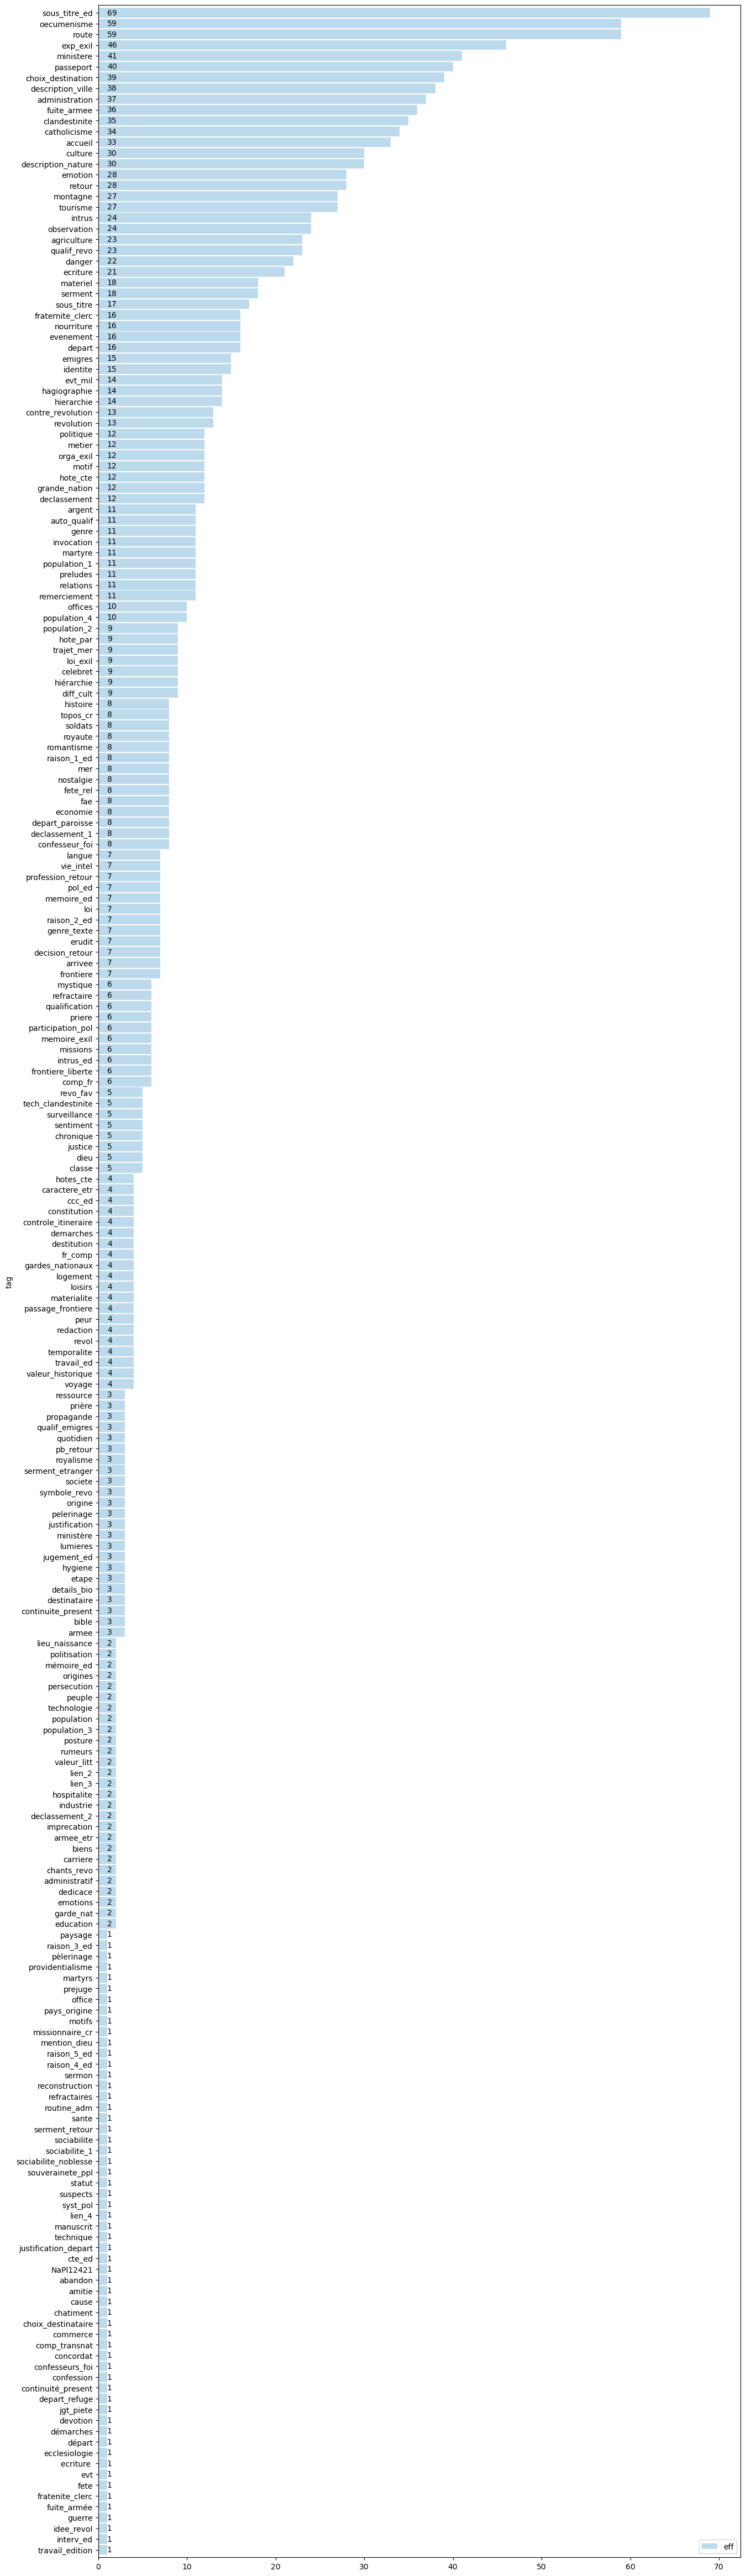

In [58]:
ax = df_results.sort_values(by='eff', ascending=True)\
        .plot(kind='barh',figsize=(15, 60), 
              color='#BDDAEC', width=0.90)
# plt.yticks(df_results.index,df_results['tag'])
#y = df_results.eff.value_counts(ascending=True)

eff = df_results.sort_values(by='eff', ascending=True).eff

for i, value in enumerate(eff):
        ax.text(1, i -.2, str(value), size=10)
plt.show()

# Tags and texts

In [59]:
tags_texts_list = []
for doc in glob_list:  ### dans le premier texte   [:1]
    doc_name = doc.replace(folder_path_xml, '')
    if doc not in bad_files:
        file = etree.parse(doc)

        ## //tei:*[contains("ptr name rs", name())]'
        """
        elements = file.xpath('//tei:name',
                              namespaces={'tei':'http://www.tei-c.org/ns/1.0'})
        """
        spans = file.xpath('//span[@class = "semAnn"][./span/@class = "tags"]')
        print(len(spans))
        i = 0

        # while i < 5:
        for s in spans:
            tags = [e.text.split('/') for e in s.xpath('span[@class = "tags"]')]
            print(tags)
            for tag in tags[0]:
                print([i,tag, tags[0]])
                tags_texts_list.append([i, doc_name,  ", ".join(tags[0]), tag, "".join(s.xpath('./text()')) ])
            i += 1

263
[['erudit']]
[0, 'erudit', ['erudit']]
[['qualification']]
[1, 'qualification', ['qualification']]
[['lien_2', 'memoire_ed']]
[2, 'lien_2', ['lien_2', 'memoire_ed']]
[2, 'memoire_ed', ['lien_2', 'memoire_ed']]
[['temporalite', 'materialite']]
[3, 'temporalite', ['temporalite', 'materialite']]
[3, 'materialite', ['temporalite', 'materialite']]
[['redaction', 'materialite']]
[4, 'redaction', ['redaction', 'materialite']]
[4, 'materialite', ['redaction', 'materialite']]
[['travail_edition']]
[5, 'travail_edition', ['travail_edition']]
[['raison_1_ed', 'hagiographie']]
[6, 'raison_1_ed', ['raison_1_ed', 'hagiographie']]
[6, 'hagiographie', ['raison_1_ed', 'hagiographie']]
[['sous_titre_ed']]
[7, 'sous_titre_ed', ['sous_titre_ed']]
[['erudit', 'details_bio']]
[8, 'erudit', ['erudit', 'details_bio']]
[8, 'details_bio', ['erudit', 'details_bio']]
[['hagiographie']]
[9, 'hagiographie', ['hagiographie']]
[['erudit', 'details_bio']]
[10, 'erudit', ['erudit', 'details_bio']]
[10, 'details_bio

In [60]:
tags_texts_list[85:90]

[[56,
  'd27_alaidon_sans.html',
  'clandestinite, preludes',
  'preludes',
  "j'y jouirais de la plus grande liberté et que je lui ferais plaisir. Je lui répondis qu'il était bien plus simple de me laisser mon église; que je le remerciais de la sienne; qu'il savait bien que nous ne pouvions plus frayer ensemble, comme autre fois; que Dieu serait le juge de ce que nous avions fait l'un et l'autre; qu'au reste je ne me repentais point de mon refus de serment, et que, si j'étais à recommencer, je le refuserais encore. Peu de temps après, il me quitta, me priant de ne point lui en vouloir : « A Dieu ne plaise, lui [16] dis-je, daigne-t-il vous éclairer, et vous rappeler à lui! » "],
 [57,
  'd27_alaidon_sans.html',
  'invocation',
  'invocation',
  "J'avais,- comme je l'ai dit plus haut, tout ce qu'il me fallait pour célébrer la sainte messe. Je me réduisis donc à m'arranger un autel dans la salle de la maison que j'habitais, ensuite dans un petit cabinet, selon la permission qui nous en 

In [61]:
df_tags_texts_list = pd.DataFrame(tags_texts_list, columns=['id', 'document', 'tags_originaux', 'tag', 'texte'])

In [62]:
chemin = 'resultats/tags_texts_list.csv'
df_tags_texts_list.to_csv(chemin, index=False)

#### Exporter dans table sqlite

In [69]:
chemin = 'resultats/tags_and_texts.sqlite'
con = sqlite3.connect(chemin)

In [70]:
### !!! Attention la table sera écrasée et réécrite entièremen à chaque exécution !!!
df_tags_texts_list.to_sql('tags_texts_list', con=con, if_exists='append')

1848

In [71]:
con.close()